<div style="text-align:center">
    <h1>
        Deep SARSA
    </h1>
</div>

<br><br>

<div style="text-align:center">

In this notebook, we extend the SARSA algorithm to use function approximators (Neural Networks). The resulting algorithm is known as Deep SARSA.
</div>

<br><br>
<div style="text-align:center">
    <b>This notebook belongs to section 8 of the course "Reinforcement Learning: beginner to master".</b>
    <br><br>
    <a href="https://www.udemy.com">Reinforcement Learning: beginner to master</a> (English)
    <br>
    <a href="https://www.udemy.com">Reinforcement Learning: de principiante a maestro</a> (Spanish)
</div>

<br>

<table style="width:35%">
  <tr style="background-color: transparent">
    <td style="width: 45%">
        <a target="_parent" href="https://www.evlabs.io" style="float: center">
            <img src="img/evlabs-square.png" width="75"/>
        </a> 
    </td>
    <td valign="bottom">
        <a target="_parent" href="https://www.youtube.com/channel/UCksRNSzWuMV5IfdrPlglqqw">
            <img src="img/YouTube.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://www.linkedin.com/company/evlabs">
            <img src="img/LinkedIn.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://twitter.com/evelabs">
            <img src="img/Twitter.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://github.com/escape-velocity-labs/">
            <img src="img/GitHub.png" width="35"/>
        </a> 
    </td>

  </tr>
  <tr style="background-color: transparent">
    <th style="text-align: center; width: 70%">Escape Velocity Labs</th>
  </tr>

</table>

<br>

## Import the necessary software libraries:

## Create and prepare the environment

### Create the environment

### Prepare the environment to work with PyTorch

## Create the Q-Network and policy

<br><br>

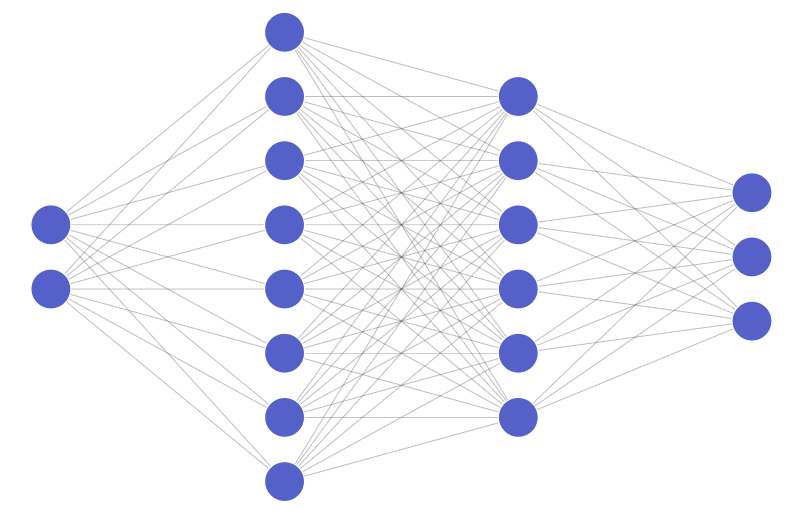

### Create the Q-Network: $\hat q(s,a| \theta)$

### Create the target Q-Network: $\hat q(s, a|\theta_{targ})$

### Create the $\epsilon$-greedy policy: $\pi(s)$

### Plot the cost to go: $ - \max_a \hat q(s,a|\theta)$

## Create the Experience Replay buffer

<br>
<div style="text-align:center">
    <p>A simple buffer that stores transitions of arbitrary values, adapted from
    <a href="https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html#training">this source.</a></p>
</div>

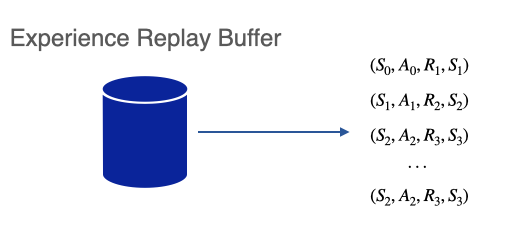


## Implement the algorithm

</br></br>

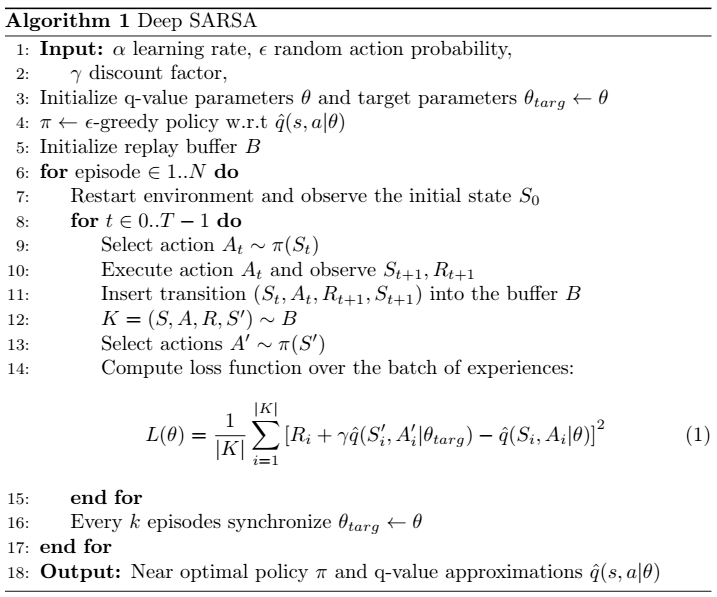

## Show results

### Plot execution stats

### Plot the cost to go: $ - \max_a \hat q(s,a|\theta)$

### Show resulting policy: $\pi(s)$

### Test the resulting agent

In [ ]:
%matplotlib inline
test_agent(env, policy, episodes=2)

## Resources

[[1] Deep Reinforcement Learning with Experience Replay Based on SARSA](https://www.researchgate.net/publication/313803199_Deep_reinforcement_learning_with_experience_replay_based_on_SARSA)